In [32]:
import json
import gzip
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download from FLIP
https://github.com/J-SNACKKB/FLIP/tree/main/splits/meltome

In [27]:
data_file = "/projects/robustmicrob/jlaw/inputs/meltome/flip/github/full_dataset_sequences.fasta"


In [28]:
# copied from here: https://stackoverflow.com/a/29805905/7483950
def read_fasta(fp, gzipped=False):
        name, seq = None, []
        for line in fp:
            if gzipped:
                line = line.decode()
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line[1:], []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

In [35]:
print(f"reading {data_file}")
data = {}
with open(data_file, 'r') as f:
    for name, seq in read_fasta(f):
        # make sure there aren't these strange AAs
        seq = seq.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
        data[name] = seq

print(f"\t{len(data)} read")

reading /projects/robustmicrob/jlaw/inputs/meltome/flip/github/full_dataset_sequences.fasta
	201283 read


In [38]:
list(data.keys())[-10:]

['Q8IYH5_HepG2 MELTING_POINT=44.2372224918082',
 'Q8IYH5_HepG2 MELTING_POINT=45.5473475301891',
 'Q8IYH5_HepG2 MELTING_POINT=48.195259181238',
 'Q8IYH5_Jurkat MELTING_POINT=44.5979508657712',
 'Q8IYH5_Jurkat MELTING_POINT=44.9185958439174',
 'Q8IYH5_Jurkat MELTING_POINT=48.9135486981963',
 'Q8IYH5_Jurkat MELTING_POINT=50.0647547651151',
 'Q8IYH5_Jurkat MELTING_POINT=50.9551567550975',
 'Q8IYH5_Jurkat MELTING_POINT=54.4209813748112',
 'Q8IYH5_colon_cancer_spheroids MELTING_POINT=50.6936083526511']

In [43]:
def build_df(data):
    table = []
    for key, seq in data.items():
        key, tm = key.split(' ')
        key = key.split('_')
        u_id = key[0]
        run_name = '_'.join(key[1:])
        tm = float(tm.replace("MELTING_POINT=",''))
    
        table.append((u_id, run_name, tm, seq))
        # exp_type = key[-1]
        # species = key[1:-1
    df = pd.DataFrame(table, columns=['uniprot', 'run_name', 'Tm', 'sequence'])
    return df
    
df = build_df(data)
df.head(2)

,uniprot,run_name,Tm,sequence
0,A0A023T4K3,Caenorhabditis_elegans_lysate,37.962947,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...
1,A0A023T778,Mus_musculus_BMDC_lysate,54.425342,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...


In [48]:
df.tail(2)

,uniprot,run_name,Tm,sequence
201281,Q8IYH5,Jurkat,54.420981,MAASRSTRVTRSTVGLNGLDESFCGRTLRNRSIAHPEEISSNSQVR...
201282,Q8IYH5,colon_cancer_spheroids,50.693608,MAASRSTRVTRSTVGLNGLDESFCGRTLRNRSIAHPEEISSNSQVR...


In [49]:
human_df = pd.read_csv("/projects/robustmicrob/jlaw/inputs/meltome/flip/human_sequences.tsv", sep='\t')
# human_ids = set(human_df['Entry'].values)

In [51]:
# separate into lysates, whole cells
data_l = df[df.run_name.apply(lambda x: 'lysate' in x)]
data_human = df[df.uniprot.isin(human_df.Entry)]
data_wc = df[~df.run_name.isin(set(data_l.run_name.values) | set(data_human.run_name.values))]
# data_wc = df[df.run_name.apply(lambda x: '_cells' in x)]

print(f"{len(data_l) =}")
print(f"{len(data_wc) =}")
print(f"{len(data_human) =}")

len(data_l) =25558
len(data_wc) =3099
len(data_human) =172628


### Take the average Tm from different cell lines

In [64]:
mean_tm = data_human[['uniprot', 'Tm']].groupby(['uniprot']).mean()
mean_tm['sequence'] = data_human[['uniprot', 'sequence']].drop_duplicates().set_index('uniprot').sequence
data_human = mean_tm
data_human.head(2)

,Tm,sequence
uniprot,,
A0A096LPI5,47.785112,MQYPFRKLLRPSTESCCVAQARVQWCHLGSLQPPLPGFKQFSCHSL...
A0AV96,48.347820,MTAEDSTAAMSSDSAAGSSAKVPEGVAGAPNEAALLALMERTGYSM...


In [73]:
mean_tm = data_l[['uniprot', 'Tm']].groupby(['uniprot']).mean()
mean_tm['sequence'] = data_l[['uniprot', 'sequence']].drop_duplicates().set_index('uniprot').sequence
data_l = mean_tm
data_l.head(2)

,Tm,sequence
uniprot,,
A0A023T4K3,37.962947,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...
A0A023T778,54.425342,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...


In [76]:
data_processed = pd.concat([data_l, data_human])
len(data_processed)

33908

In [80]:
data_processed = data_processed[data_processed.sequence.apply(lambda x: len(x) < 5000)]

<AxesSubplot: >

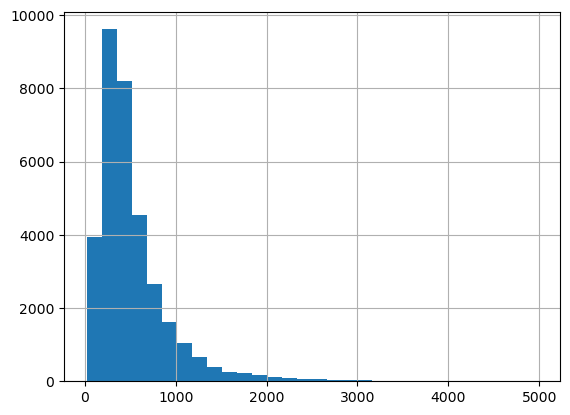

In [81]:
data_processed.sequence.apply(len).hist(bins=30)

In [77]:
out_file = "/projects/robustmicrob/jlaw/inputs/meltome/20230125_meltome_flip.csv"
data_processed.to_csv(out_file)

### TODO how should non-melters be handled

### TODO how should lysates vs whole cells be handled?

In [53]:
data_wc.run_name.value_counts()

Escherichia_coli_cells             1951
Thermus_thermophilus_HB27_cells    1148
Name: run_name, dtype: int64

### Backup: parsing myself

In [2]:
meltome_file = "/projects/robustmicrob/jlaw/inputs/meltome/flip/cross-species.csv"
data_sp = pd.read_csv(meltome_file)
print(len(data_sp))
data_sp.head(2)

/tmp/ipykernel_3461/267470526.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data_sp = pd.read_csv(meltome_file)


1114710


,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature
0,Bacillus subtilis_168_lysate_R1,C0H3Q1_ytzI,ytzI,NaN,TMT126,0.999203,30.0
1,Bacillus subtilis_168_lysate_R1,C0H3V2_mtlF,mtlF,56.693844,TMT126,0.999203,30.0


In [56]:
data_sp[data_sp.Protein_ID == "A0A061AD41_B0513.5"]

,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature
23113,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT126,0.999270,25.0
68739,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT127H,1.000463,31.0
114365,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT127L,1.063722,27.9
159991,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT128H,0.913197,38.2
205617,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT128L,1.135860,34.6
251243,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT129H,0.744963,45.4
296869,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT129L,0.870272,41.8
342495,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT130H,0.945017,52.1
388121,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT130L,1.012457,49.0
433747,Caenorhabditis elegans lysate,A0A061AD41_B0513.5,B0513.5,NaN,TMT131L,0.601203,55.0


In [54]:
data_sp.run_name.value_counts()

Homo sapiens Jurkat cells                      336290
Homo sapiens K562 cells                        322160
Mus musculus BMDC lysate                       121920
Caenorhabditis elegans lysate                   60330
Mus musculus liver lysate                       45930
Arabidopsis thaliana seedling lysate            29670
Danio rerio Zenodo lysate                       23770
Escherichia coli cells                          22120
Escherichia coli lysate                         21710
Saccharomyces cerevisiae lysate                 21660
Oleispira antarctica_RB-8_lysate_R1             19240
Bacillus subtilis_168_lysate_R1                 19200
Drosophila melanogaster SII lysate              17360
Thermus thermophilus HB27 cells                 16640
Thermus thermophilus HB27 lysate                15960
Geobacillus stearothermophilus NCA26 lysate     10610
Picrophilus torridus DSM9790 lysate             10140
Name: run_name, dtype: int64

In [14]:
# map human gene names to uniprot IDs
df = pd.read_csv("/projects/bpms/jlaw/inputs/uniprot/2023-01/human_9606_id_mapping.tab.gz", sep='\t')
df.head(2)

,Entry,Gene Names,Length,Gene Names (primary),Protein names
0,A0A087X1C5,CYP2D7,515,CYP2D7,Putative cytochrome P450 2D7 (EC 1.14.14.1)
1,A0A0B4J2F0,PIGBOS1,54,PIGBOS1,Protein PIGBOS1 (PIGB opposite strand protein 1)


In [20]:
gene_to_uniprot = dict(zip(df['Gene Names'], df['Entry']))
for gene_name, u_id in df[['Gene Names', 'Entry']].values:
    if pd.isnull(gene_name): continue
    for name in gene_name.split(' '):
        gene_to_uniprot[name] = u_id

data_sp.loc[pd.isnull(data_sp.Protein_ID), "Protein_ID"] = data_sp[pd.isnull(data_sp.Protein_ID)].gene_name.apply(
    lambda x: f"{gene_to_uniprot[x.upper().replace('-','')]}_{x}" if x.upper().replace('-','') in gene_to_uniprot else np.nan)
data_sp.tail()

,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature
1114705,Homo sapiens Jurkat cells,P42345_mTOR,mTOR,47.997427,NaN,0.008585,67.0
1114706,Homo sapiens K562 cells,P42345_mTOR,mTOR,47.902475,NaN,0.015625,67.0
1114707,Homo sapiens K562 cells,P42345_mTOR,mTOR,47.605150,NaN,0.017599,67.0
1114708,Homo sapiens K562 cells,P42345_mTOR,mTOR,49.009148,NaN,0.018291,67.0
1114709,Homo sapiens K562 cells,P42345_mTOR,mTOR,48.890733,NaN,0.011549,67.0


In [21]:
print(len(data_sp), len(data_sp.dropna(subset='Protein_ID')))

1114710 1083400


In [22]:
gene_to_uniprot['ARPP19']

'P56211'

In [25]:
df[df['Entry'] == 'Q9UBB4']

,Entry,Gene Names,Length,Gene Names (primary),Protein names
13070,Q9UBB4,ATXN10 SCA10,475,ATXN10,Ataxin-10 (Brain protein E46 homolog) (Spinoce...


In [26]:
data_sp[pd.isnull(data_sp.Protein_ID)].gene_name.value_counts()

ch-TOG                           150
CXORF15                          150
EIF1AP1                          150
DJ-1                             150
C17ORF70                         150
                                ... 
LOC100132499                      10
C15ORF15                          10
LOC100129905                      10
C15ORF39                          10
ALPHA-ENOLASE, LUNG SPECIFIC.     10
Name: gene_name, Length: 450, dtype: int64

In [ ]:
data_sp = data_sp[["run_name", "Protein_ID", "gene_name", "meltPoint", "channel"]]

In [ ]:
# average across the different channels
data_sp.groupby(["run_name", "Protein_ID"